## Training

### Load Training data

In [ ]:
import gdown

# Link to your file (ID extracted from the URL)
file_id = "1j0SdyJ8gMrLtpFl1gDJ83s41TyUkKqUt"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.tsv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1j0SdyJ8gMrLtpFl1gDJ83s41TyUkKqUt
To: /content/dataset.tsv
100%|██████████| 78.4M/78.4M [00:00<00:00, 140MB/s]


'dataset.tsv'

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 10000)

In [ ]:
df = pd.read_csv("dataset.tsv", sep="\t")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.duplicated().sum()

92

In [ ]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29908 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    29908 non-null  object
 1   text     29908 non-null  object
 2   subject  29908 non-null  object
 3   date     29908 non-null  object
 4   label    29908 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
df.label.sum()

14432

In [ ]:
# Combine features into one text field
df['combined_text'] = (
    "Title: " + df['title'] + " | " +
    "Subject: " + df['subject'] + " | " +
    "Date: " + df['date'] + " | "
    "Text: " + df['text']
)

In [ ]:
max_length = df['combined_text'].str.len().max()
print(f"The maximum length of the 'combined_text' column is: {max_length}")

The maximum length of the 'combined_text' column is: 51956


In [ ]:
(df['combined_text'].str.len() > 8000).sum()

473

In [ ]:
df[df['combined_text'].str.len() > 8000]['label'].sum()

63

In [ ]:
df['combined_text'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Title: Ex-CIA head says Trump remarks on Russia interference 'disgraceful' | Subject: politicsNews | Date: July 22, 2017  | Text: Former CIA director John Brennan on Friday criticized as “disgraceful” President Donald Trump’s efforts to play down U.S. intelligence agencies’ assessment that Russia meddled in the 2016 U.S. election. Trump’s administration has been dogged by investigations into allegations of Russian interference in last year’s U.S. presidential election and possible ties with his campaign team. Speaking one day before his first meeting with Russian President Vladimir Putin in Hamburg earlier this month, Trump said he suspected Russian interference in the election but that no one knows for sure. “These types of comments are just disgraceful ... and the person who said them should be ashamed of himself,” said Brennan, CIA chief under former President Barack Obama, at the Aspen Security Forum. Special Counsel Robert Mueller and several U.S. congressional committees are investigating whether Russia interfered in the election and colluded with Trump’s campaign to try to swing the race in his favor over Democratic rival Hillary Clinton.  Those probes are focused almost exclusively on Moscow’s actions, lawmakers and intelligence officials have said, and no evidence has surfaced publicly implicating other countries. Moscow has denied any interference, and Trump has said that  his campaign did not collude with Russia. Brennan said he was disappointed by the president’s handling of security issues in his first six months in office. “I must say there are disappointments that I see in terms of what Mr. Trump is doing on the international stage that I think pose serious questions about how he is keeping safe our national security,” Brennan said. Speaking at the same event in Aspen, James Clapper, the former director of national intelligence under Obama, was also critical of Trump’s administration. Asked if Jared Kushner, Trump’s son-in-law and top adviser, should have his security clearance canceled for initially failing to list on a disclosure form contacts he had with Russians, Clapper said it should be suspended pending a review. “I do think the appropriate thing here is take a pause and at least suspend a clearance until you’ve had the opportunity to investigate and then decide whether the clearance should be restored or not,” Clapper told the same panel. Brennan and Clapper also criticized Trump’s remarks in a tweet earlier this year about U.S. spy agencies in which he accused them of practices reminiscent of Nazi Germany.  “That (tweet) was a terrible insulting affront not to me or John. We get paid the big bucks to take

### Load necessary module for fine-tuning

In [19]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets triton

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ff3t48wj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ff3t48wj
  Resolved https://github.com/huggingface/transformers.git to commit 5c75087aeee7081025370e10d1f571a11600f1ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
torch.cuda.empty_cache()

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from transformers import DataCollatorWithPadding

In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.cuda.get_device_capability(0))  # Should be >= 8.0 for Flash Attention

Tesla T4
True
(7, 5)


In [ ]:
model_id = "answerdotai/ModernBERT-base"

# Load the tokenizer for ModernBERT
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Load the pre-trained ModernBERT model for sequence classification with Flash Attention
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=1,
    # attn_implementation="flash_attention_2",  # Enable Flash Attention 2.0
    torch_dtype=torch.float32,      # Use mixed precision for efficiency
).to("cuda")

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare dataset for training

In [ ]:
# Tokenize the combined text
def tokenize_data(batch):
    return tokenizer(
        batch['combined_text'],
        truncation=True,
        padding='longest',  # Use dynamic padding to the longest sequence in the batch
        max_length=7000,
        return_tensors="pt"
    )

In [ ]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(pd.DataFrame(df['combined_text']))

In [ ]:
# Tokenize the dataset in batches
batch_size = 16  # Adjust based on memory capacity
tokenized_dataset = dataset.map(tokenize_data, batched=True, batch_size=batch_size)

Map:   0%|          | 0/29908 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['combined_text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 29908
})

In [ ]:
# Remove the original combined_text column to save memory
tokenized_dataset = tokenized_dataset.remove_columns(['combined_text'])
# Add the labels to the tokenized dataset
tokenized_dataset = tokenized_dataset.add_column('label', Dataset.from_pandas(pd.DataFrame(df.label))['label'])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_test = tokenized_dataset.train_test_split(test_size=0.15)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Convert the dataset to PyTorch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
train_dataset

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'label'],
    num_rows: 25421
})

### Training loop

In [ ]:
# Define custom data collator
class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Ensure input_ids are in long format
        batch['input_ids'] = batch['input_ids'].long()  # Convert input_ids to long
        # Convert other tensors to FP16 if needed
        # for key in batch.keys():
        #     if key != 'input_ids':
        #         batch[key] = batch[key].half()  # Convert other inputs to FP16

        # Convert labels to float16 if they are in FP32
        if 'labels' in batch:
            batch['labels'] = batch['labels'].float()  # Ensure labels are in FP16

        return batch

data_collator = CustomDataCollator(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,  # Adjust based on GPU memory
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
    fp16=False,  # Enable mixed precision
    dataloader_num_workers=2,
    gradient_accumulation_steps=4,  # Accumulate gradients for 4 steps
    # fp16_full_eval=True,
)

# Define a Trainer with AMP
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator
)

# Fine-tune the model
trainer.train()

TrainOutput(global_step=6355, training_loss=0.021927670485696906, metrics={'train_runtime': 6876.3305, 'train_samples_per_second': 3.697, 'train_steps_per_second': 0.924, 'total_flos': 2.598128586619892e+16, 'train_loss': 0.021927670485696906, 'epoch': 0.9999606624444357})

### Save and download model

In [ ]:
# Save the model
trainer.save_model('./saved_model')  # Specify the directory to save the model
tokenizer.save_pretrained('./saved_model')  # Save the tokenizer

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/tokenizer.json')

In [ ]:
import shutil
import os

# Create a zip file of the saved model directory
shutil.make_archive('./saved_model', 'zip', './saved_model')

# Download the zip file
from google.colab import files
files.download('./saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

Sun Dec 29 11:35:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              31W /  70W |  11167MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Testing

In [1]:
!gdown --id 1fJOaVhtwzQuzpse8OtJSmV5UZjIuR_kN

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fJOaVhtwzQuzpse8OtJSmV5UZjIuR_kN
To: /content/test.tsv
100% 22.0M/22.0M [00:00<00:00, 54.1MB/s]


In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', 10000)
test = pd.read_csv("test.tsv", sep="\t")
test.drop(columns=["Unnamed: 0"], inplace=True)
test.duplicated().sum()

10

In [2]:
test.drop_duplicates(inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8257 entries, 0 to 8266
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    8257 non-null   object
 1   text     8257 non-null   object
 2   subject  8257 non-null   object
 3   date     8257 non-null   object
 4   label    8257 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 387.0+ KB


In [3]:
# Combine features into one text field
test['combined_text'] = (
    "Title: " + test['title'] + " | " +
    "Subject: " + test['subject'] + " | " +
    "Date: " + test['date'] + " | "
    "Text: " + test['text']
)

In [6]:
import torch
torch.cuda.empty_cache()

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from transformers import DataCollatorWithPadding

In [11]:
!gdown --id 1VCcfo0RxfjCPD7JBlWpx0_Z63Cmeur89

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1VCcfo0RxfjCPD7JBlWpx0_Z63Cmeur89
From (redirected): https://drive.google.com/uc?id=1VCcfo0RxfjCPD7JBlWpx0_Z63Cmeur89&confirm=t&uuid=45c74e96-b387-4a05-957d-a462046d1454
To: /content/saved_model.zip
100% 557M/557M [00:24<00:00, 23.1MB/s]


In [12]:
import zipfile
import os

zip_file_path = '/content/saved_model.zip'
unzip_dir = 'model_directory'  # Directory to extract to

# Create the directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

In [13]:
model_name = unzip_dir
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [14]:
# Tokenize the combined text
def tokenize_data(batch):
    return tokenizer(
        batch['combined_text'],
        truncation=True,
        padding='longest',  # Use dynamic padding to the longest sequence in the batch
        max_length=7000,
        return_tensors="pt"
    )

In [15]:
# Convert to Hugging Face Dataset
test_dataset = Dataset.from_pandas(pd.DataFrame(test['combined_text']))

# Tokenize the dataset in batches
batch_size = 16  # Adjust based on memory capacity
tokenized_dataset = test_dataset.map(tokenize_data, batched=True, batch_size=batch_size)

Map:   0%|          | 0/8257 [00:00<?, ? examples/s]

In [16]:
# Set format for PyTorch
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [17]:
from torch.utils.data import DataLoader

# Define DataLoader
test_dataloader = DataLoader(tokenized_dataset, batch_size=batch_size)

In [23]:
from tqdm import tqdm
import torch._dynamo

# Disable Dynamo optimizations
torch._dynamo.config.suppress_errors = True



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set model to evaluation mode

predictions = []
probabilities = []  # To store probabilities if needed

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Running Inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Ensure logits is 1D for binary classification

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Convert probabilities to binary predictions

        # Store results
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

Running Inference: 100%|██████████| 517/517 [28:36<00:00,  3.32s/it]


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Ground truth labels (true values from your dataset)
true_labels = test['label']

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc_roc = roc_auc_score(true_labels, probabilities)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7027
Precision: 0.6181
Recall: 1.0000
F1 Score: 0.7640
AUC-ROC: 1.0000


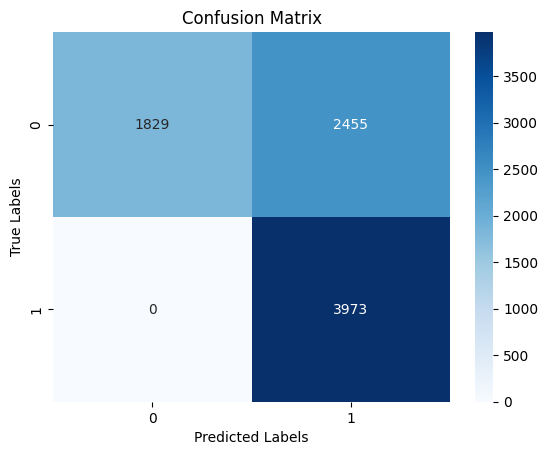

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
probabilities

[0.50001657,
 0.73180765,
 0.50006306,
 0.73142564,
 0.500457,
 0.730648,
 0.49988672,
 0.5000267,
 0.49966726,
 0.5005572,
 0.7317519,
 0.7308919,
 0.73081124,
 0.49979952,
 0.49989775,
 0.50000733,
 0.73092675,
 0.5000122,
 0.7308941,
 0.7307099,
 0.49981403,
 0.4999174,
 0.73107773,
 0.5001563,
 0.5001094,
 0.73106664,
 0.49960276,
 0.7304853,
 0.4989315,
 0.73073626,
 0.49933076,
 0.7307914,
 0.4995961,
 0.7309542,
 0.7305881,
 0.730756,
 0.730791,
 0.73154485,
 0.73174363,
 0.7310429,
 0.500371,
 0.5003924,
 0.49990276,
 0.73099464,
 0.49985507,
 0.73004943,
 0.7308039,
 0.7303853,
 0.7312729,
 0.50049806,
 0.73019195,
 0.73089105,
 0.73086566,
 0.49970746,
 0.5002459,
 0.73114836,
 0.49987105,
 0.5000737,
 0.73095727,
 0.500732,
 0.7308521,
 0.7298369,
 0.7311641,
 0.5000605,
 0.49954134,
 0.7313265,
 0.5002616,
 0.5000128,
 0.4991023,
 0.7312981,
 0.5001435,
 0.7309735,
 0.73123676,
 0.5000661,
 0.73077166,
 0.5004365,
 0.73055613,
 0.49987772,
 0.7314142,
 0.4999144,
 0.7311296

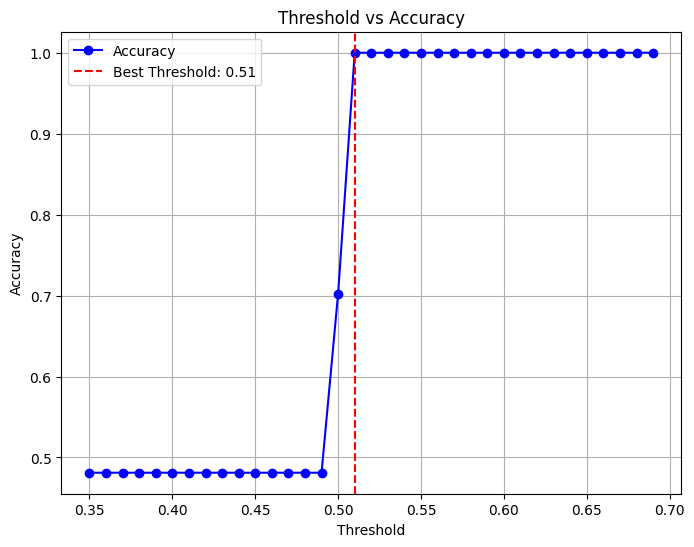

Best Threshold: 0.51
Best Accuracy: 1.0000


In [37]:
import numpy as np

# Generate thresholds to test (e.g., from 0.0 to 1.0 with a step of 0.01)
thresholds = np.arange(0.35, 0.70, 0.01)

# Lists to store thresholds and corresponding accuracies
accuracies = []

# Initialize variables to store the best threshold and highest accuracy
best_threshold = 0.0
best_accuracy = 0.0

# Loop through thresholds to calculate accuracy
for threshold in thresholds:
    # Convert probabilities to binary predictions using the current threshold
    predictions = (probabilities >= threshold).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    accuracies.append(accuracy)

    # Update best threshold if current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Plot accuracy vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, marker='o', label='Accuracy', color='blue')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title("Threshold vs Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Print the optimal threshold and corresponding accuracy
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000


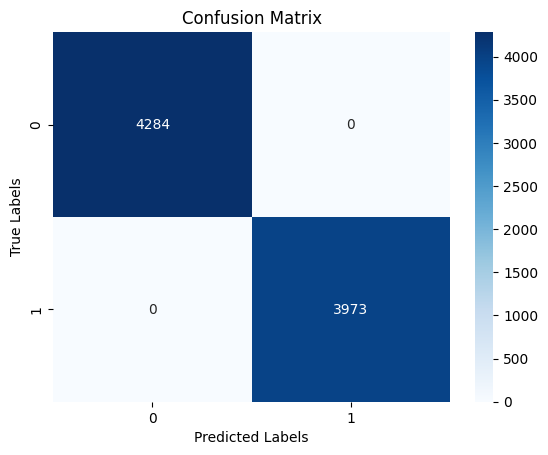

In [39]:
# Predictions corresponding to best_threshold
predictions = (probabilities >= best_threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc_roc = roc_auc_score(true_labels, probabilities)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Pipeline

In [51]:
# Define the prediction pipeline
def predict_pipeline(input_df, tokenizer, model):

    model.eval()  # Set model to evaluation mode

    # Combine inputs into a single text column (you can customize this)
    input_df['combined_text'] = (
        "Title: " + input_df['title'] + " | " +
        "Subject: " + input_df['subject'] + " | " +
        "Date: " + input_df['date'] + " | "
        "Text: " + input_df['text']
    )

    # Tokenize the combined text
    tokenized = tokenizer(
        input_df['combined_text'].tolist(),
        truncation=True,
        padding='longest',
        max_length=7000,
        return_tensors="pt"
    )

    # Move tensors to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = tokenized['input_ids'].to(device)
    attention_mask = tokenized['attention_mask'].to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Ensure logits is 1D for binary classification

    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(logits)
    preds = (probs > 0.51).long()

    # Combine results into desired format
    results = [{"title": row['title'], "predicted_class": pred_class.item()}
               for row, pred_class in zip(input_df.to_dict(orient='records'), preds)]

    return results

In [52]:
# Example DataFrame
data = {
    "title": ["Trump's new policy reviewed", "Shocking claims about health!"],
    "text": ["Policy details are emerging about new measures.", "A new study claims unbelievable results."],
    "subject": ["Politics", "Health"],
    "date": ["2024-12-28", "2024-12-29"]
}
input_df = pd.DataFrame(data)

# Run the prediction pipeline
output = predict_pipeline(input_df, tokenizer, model)

# Display the output
print(output)

[{'title': "Trump's new policy reviewed", 'predicted_class': 0}, {'title': 'Shocking claims about health!', 'predicted_class': 0}]
